# Credit Risk Assessment - XGBoost Model (SMOTE-Balanced)

This notebook trains an XGBoost model using **preprocessed data with SMOTE** from the data pipeline.

**What this notebook does:**
1. Load preprocessed data (with SMOTE already applied)
2. Train XGBoost model
3. Optimize classification threshold
4. Calibrate probabilities
5. Evaluate performance

**Data Pipeline Handles:**
- ✅ Data loading
- ✅ Train/val/test splits
- ✅ Preprocessing
- ✅ Feature engineering (12 risk indicators)
- ✅ SMOTE resampling (verified)
- ✅ Saved to `data/processed/`

## 1. Setup and Load Data

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd

from src.data_pipeline import load_processed_data
from src.config import MODELS_DIR, XGBOOST_PARAMS
from src.models.xgboost_model import XGBoostModel
from src.evaluation import ModelEvaluator
from src.utils import setup_logging, set_seed

# Setup
setup_logging()
set_seed(42)

print("✓ Imports successful!")

✓ Imports successful!


In [2]:
print("="*80)
print("LOADING PREPROCESSED DATA (WITH SMOTE)")
print("="*80)

# Load preprocessed data from data pipeline
X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data()

print(f"\n✓ Data loaded successfully!")
print(f"\nDataset sizes:")
print(f"  Training: {len(X_train):,} samples, {X_train.shape[1]} features")
print(f"  Validation: {len(X_val):,} samples")
print(f"  Test: {len(X_test):,} samples")

print(f"\nTraining set class distribution (SMOTE-balanced):")
train_dist = y_train.value_counts().sort_index()
print(f"  Class 0 (good): {train_dist[0]:,} ({train_dist[0]/len(y_train)*100:.1f}%)")
print(f"  Class 1 (bad): {train_dist[1]:,} ({train_dist[1]/len(y_train)*100:.1f}%)")
print(f"  Imbalance ratio: {train_dist[0]/train_dist[1]:.2f}:1")

print(f"\nValidation set class distribution (original):")
val_dist = y_val.value_counts().sort_index()
print(f"  Class 0 (good): {val_dist.iloc[0]:,} ({val_dist.iloc[0]/len(y_val)*100:.1f}%)")
print(f"  Class 1 (bad): {val_dist.iloc[1]:,} ({val_dist.iloc[1]/len(y_val)*100:.1f}%)")
print(f"  Imbalance ratio: {val_dist.iloc[0]/val_dist.iloc[1]:.2f}:1")

INFO:src.data_pipeline:Loading processed data...


LOADING PREPROCESSED DATA (WITH SMOTE)


INFO:src.data_pipeline:✓ Training data (SMOTE-balanced): (364313, 103)
INFO:src.data_pipeline:✓ Validation data: (75000, 103)
INFO:src.data_pipeline:✓ Test data: (100000, 103)



✓ Data loaded successfully!

Dataset sizes:
  Training: 364,313 samples, 103 features
  Validation: 75,000 samples
  Test: 100,000 samples

Training set class distribution (SMOTE-balanced):
  Class 0 (good): 260,224 (71.4%)
  Class 1 (bad): 104,089 (28.6%)
  Imbalance ratio: 2.50:1

Validation set class distribution (original):
  Class 0 (good): 60,052 (80.1%)
  Class 1 (bad): 14,948 (19.9%)
  Imbalance ratio: 4.02:1


## 2. Train XGBoost Model

In [3]:
print("="*80)
print("TRAINING XGBOOST MODEL ON SMOTE-BALANCED DATA")
print("="*80)

# Prepare parameters
params = XGBOOST_PARAMS.copy()

# Adjust scale_pos_weight for SMOTE-balanced data
params['scale_pos_weight'] = train_dist[0] / train_dist[1]

print(f"\nModel parameters:")
print(f"  scale_pos_weight: {params['scale_pos_weight']:.2f}")
print(f"  learning_rate: {params['learning_rate']}")
print(f"  max_depth: {params['max_depth']}")
print(f"  n_estimators: {params['n_estimators']}")

print(f"\nTraining model...\n")

# Train model
xgb_model = XGBoostModel(params=params)
xgb_model.train(
    X_train, y_train,  # SMOTE-balanced training data
    X_val, y_val,      # Original validation data
    verbose=True
)

# Save model
model_path = MODELS_DIR / 'xgboost_smote_improved.pkl'
xgb_model.save_model(model_path)
print(f"\n✓ Model saved to {model_path}")

2025-12-10 16:33:11,090 - credit_risk_fyp.models.xgboost - INFO - Training XGBoost model...
INFO:credit_risk_fyp.models.xgboost:Training XGBoost model...
2025-12-10 16:33:11,094 - credit_risk_fyp.models.xgboost - INFO - Training set size: 364,313 samples, 103 features
INFO:credit_risk_fyp.models.xgboost:Training set size: 364,313 samples, 103 features
2025-12-10 16:33:11,104 - credit_risk_fyp.models.xgboost - INFO - Class distribution - 0: 260,224, 1: 104,089
INFO:credit_risk_fyp.models.xgboost:Class distribution - 0: 260,224, 1: 104,089
2025-12-10 16:33:11,108 - credit_risk_fyp.models.xgboost - INFO - Scale pos weight: 2.5000
INFO:credit_risk_fyp.models.xgboost:Scale pos weight: 2.5000


TRAINING XGBOOST MODEL ON SMOTE-BALANCED DATA

Model parameters:
  scale_pos_weight: 2.50
  learning_rate: 0.05
  max_depth: 8
  n_estimators: 1000

Training model...



2025-12-10 16:33:11,628 - credit_risk_fyp.models.xgboost - INFO - Validation set size: 75,000 samples
INFO:credit_risk_fyp.models.xgboost:Validation set size: 75,000 samples


[0]	train-auc:0.75868	val-auc:0.64646
[50]	train-auc:0.83301	val-auc:0.71395
[100]	train-auc:0.84813	val-auc:0.72231
[150]	train-auc:0.85898	val-auc:0.72500
[200]	train-auc:0.86771	val-auc:0.72625
[250]	train-auc:0.87632	val-auc:0.72689
[291]	train-auc:0.88304	val-auc:0.72680


2025-12-10 16:34:12,965 - credit_risk_fyp.models.xgboost - INFO - [OK] Training complete. Best iteration: 241
INFO:credit_risk_fyp.models.xgboost:[OK] Training complete. Best iteration: 241
2025-12-10 16:34:12,969 - credit_risk_fyp.models.xgboost - INFO - [OK] Validation AUC: 0.7270
INFO:credit_risk_fyp.models.xgboost:[OK] Validation AUC: 0.7270
2025-12-10 16:34:13,061 - credit_risk_fyp.models.xgboost - INFO - Saved XGBoost model to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl
INFO:credit_risk_fyp.models.xgboost:Saved XGBoost model to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl


✓ Saved object to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl

✓ Model saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl


## 3. Make Predictions

In [4]:
print("Making predictions...")

y_val_proba = xgb_model.predict_proba(X_val)
y_test_proba = xgb_model.predict_proba(X_test)

print(f"\n✓ Validation predictions: {len(y_val_proba):,}")
print(f"✓ Test predictions: {len(y_test_proba):,}")

Making predictions...

✓ Validation predictions: 75,000
✓ Test predictions: 100,000


## 4. Optimize Classification Threshold

In [5]:
print("="*80)
print("OPTIMIZING CLASSIFICATION THRESHOLD")
print("="*80)

evaluator = ModelEvaluator()

# Find optimal thresholds for different metrics
print("\nFinding optimal thresholds on validation set:\n")

optimal_thresholds = {}
for metric in ['f1', 'precision', 'recall']:
    threshold, score = evaluator.optimize_threshold(
        y_val, y_val_proba, metric=metric
    )
    optimal_thresholds[metric] = threshold
    print(f"{metric.upper():<15} Optimal threshold: {threshold:.4f}, Score: {score:.4f}")

# Use F1-optimized threshold as default
optimal_threshold = optimal_thresholds['f1']
print(f"\n✓ Using F1-optimized threshold: {optimal_threshold:.4f}")

OPTIMIZING CLASSIFICATION THRESHOLD

Finding optimal thresholds on validation set:



2025-12-10 16:34:15,059 - credit_risk_fyp.evaluation - INFO - Optimal threshold for f1: 0.4242 (score: 0.4418)
INFO:credit_risk_fyp.evaluation:Optimal threshold for f1: 0.4242 (score: 0.4418)


F1              Optimal threshold: 0.4242, Score: 0.4418


2025-12-10 16:34:16,070 - credit_risk_fyp.evaluation - INFO - Optimal threshold for precision: 0.8990 (score: 1.0000)
INFO:credit_risk_fyp.evaluation:Optimal threshold for precision: 0.8990 (score: 1.0000)


PRECISION       Optimal threshold: 0.8990, Score: 1.0000


2025-12-10 16:34:16,855 - credit_risk_fyp.evaluation - INFO - Optimal threshold for recall: 0.0000 (score: 1.0000)
INFO:credit_risk_fyp.evaluation:Optimal threshold for recall: 0.0000 (score: 1.0000)


RECALL          Optimal threshold: 0.0000, Score: 1.0000

✓ Using F1-optimized threshold: 0.4242


## 5. Probability Calibration

In [6]:
print("="*80)
print("PROBABILITY CALIBRATION (ISOTONIC REGRESSION)")
print("="*80)

# Calibrate validation set probabilities
y_val_calibrated, cal_metrics_val = evaluator.calibrate_probabilities(
    y_val, y_val_proba, method='isotonic'
)

print(f"\nValidation Set Calibration Results:")
print(f"  Method: {cal_metrics_val['method']}")
print(f"  Brier Score: {cal_metrics_val['brier_score_before']:.4f} → {cal_metrics_val['brier_score_after']:.4f} "
      f"(improvement: {cal_metrics_val['brier_improvement']:+.4f})")
print(f"  Log Loss: {cal_metrics_val['log_loss_before']:.4f} → {cal_metrics_val['log_loss_after']:.4f} "
      f"(improvement: {cal_metrics_val['log_loss_improvement']:+.4f})")
print(f"  Expected Calibration Error: {cal_metrics_val['ece_before']:.4f} → {cal_metrics_val['ece_after']:.4f} "
      f"(improvement: {cal_metrics_val['ece_improvement']:+.4f})")

# Calibrate test set probabilities
y_test_calibrated, cal_metrics_test = evaluator.calibrate_probabilities(
    y_test, y_test_proba, method='isotonic'
)

print(f"\nTest Set Calibration Results:")
print(f"  Method: {cal_metrics_test['method']}")
print(f"  Brier Score: {cal_metrics_test['brier_score_before']:.4f} → {cal_metrics_test['brier_score_after']:.4f} "
      f"(improvement: {cal_metrics_test['brier_improvement']:+.4f})")
print(f"  Log Loss: {cal_metrics_test['log_loss_before']:.4f} → {cal_metrics_test['log_loss_after']:.4f} "
      f"(improvement: {cal_metrics_test['log_loss_improvement']:+.4f})")
print(f"  Expected Calibration Error: {cal_metrics_test['ece_before']:.4f} → {cal_metrics_test['ece_after']:.4f} "
      f"(improvement: {cal_metrics_test['ece_improvement']:+.4f})")

print(f"\n✓ Probability calibration complete!")

2025-12-10 16:34:16,874 - credit_risk_fyp.evaluation - INFO - Calibrating probabilities using isotonic method...
INFO:credit_risk_fyp.evaluation:Calibrating probabilities using isotonic method...
2025-12-10 16:34:16,962 - credit_risk_fyp.evaluation - INFO - Calibration complete:
INFO:credit_risk_fyp.evaluation:Calibration complete:
2025-12-10 16:34:16,965 - credit_risk_fyp.evaluation - INFO -   Brier score: 0.1661 → 0.1412 (improvement: 0.0249)
INFO:credit_risk_fyp.evaluation:  Brier score: 0.1661 → 0.1412 (improvement: 0.0249)
2025-12-10 16:34:16,968 - credit_risk_fyp.evaluation - INFO -   Log loss: 0.5054 → 0.4437 (improvement: 0.0617)
INFO:credit_risk_fyp.evaluation:  Log loss: 0.5054 → 0.4437 (improvement: 0.0617)
2025-12-10 16:34:16,971 - credit_risk_fyp.evaluation - INFO -   ECE: 0.1456 → 0.0000 (improvement: 0.1456)
INFO:credit_risk_fyp.evaluation:  ECE: 0.1456 → 0.0000 (improvement: 0.1456)
2025-12-10 16:34:16,974 - credit_risk_fyp.evaluation - INFO - Calibrating probabilities 

PROBABILITY CALIBRATION (ISOTONIC REGRESSION)

Validation Set Calibration Results:
  Method: isotonic
  Brier Score: 0.1661 → 0.1412 (improvement: +0.0249)
  Log Loss: 0.5054 → 0.4437 (improvement: +0.0617)
  Expected Calibration Error: 0.1456 → 0.0000 (improvement: +0.1456)


INFO:credit_risk_fyp.evaluation:Calibration complete:
2025-12-10 16:34:17,059 - credit_risk_fyp.evaluation - INFO -   Brier score: 0.1666 → 0.1419 (improvement: 0.0247)
INFO:credit_risk_fyp.evaluation:  Brier score: 0.1666 → 0.1419 (improvement: 0.0247)
2025-12-10 16:34:17,061 - credit_risk_fyp.evaluation - INFO -   Log loss: 0.5069 → 0.4457 (improvement: 0.0612)
INFO:credit_risk_fyp.evaluation:  Log loss: 0.5069 → 0.4457 (improvement: 0.0612)
2025-12-10 16:34:17,064 - credit_risk_fyp.evaluation - INFO -   ECE: 0.1822 → 0.0000 (improvement: 0.1822)
INFO:credit_risk_fyp.evaluation:  ECE: 0.1822 → 0.0000 (improvement: 0.1822)



Test Set Calibration Results:
  Method: isotonic
  Brier Score: 0.1666 → 0.1419 (improvement: +0.0247)
  Log Loss: 0.5069 → 0.4457 (improvement: +0.0612)
  Expected Calibration Error: 0.1822 → 0.0000 (improvement: +0.1822)

✓ Probability calibration complete!



Generating calibration plots...


2025-12-10 16:34:18,242 - credit_risk_fyp.evaluation - INFO - Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_xgboost_smote_validation.png
INFO:credit_risk_fyp.evaluation:Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_xgboost_smote_validation.png
2025-12-10 16:34:18,989 - credit_risk_fyp.evaluation - INFO - Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_xgboost_smote_test.png
INFO:credit_risk_fyp.evaluation:Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_xgboost_smote_test.png


✓ Calibration curves saved


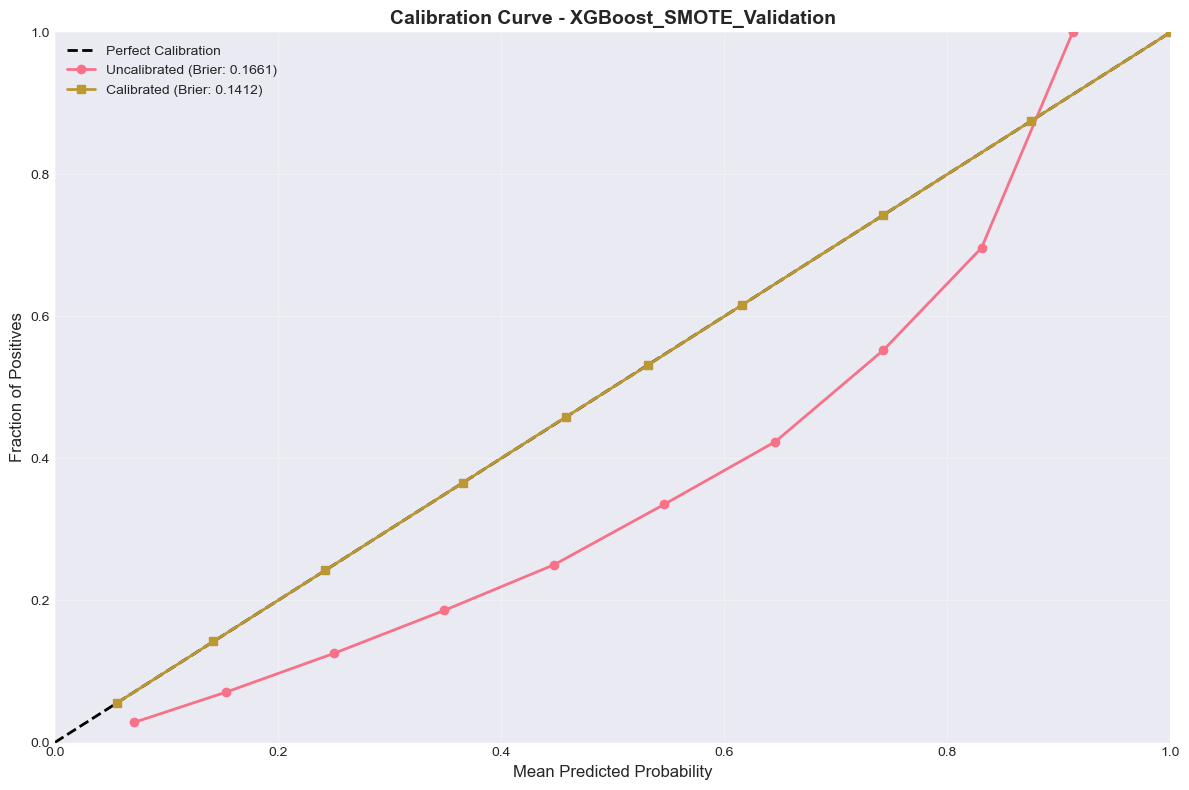

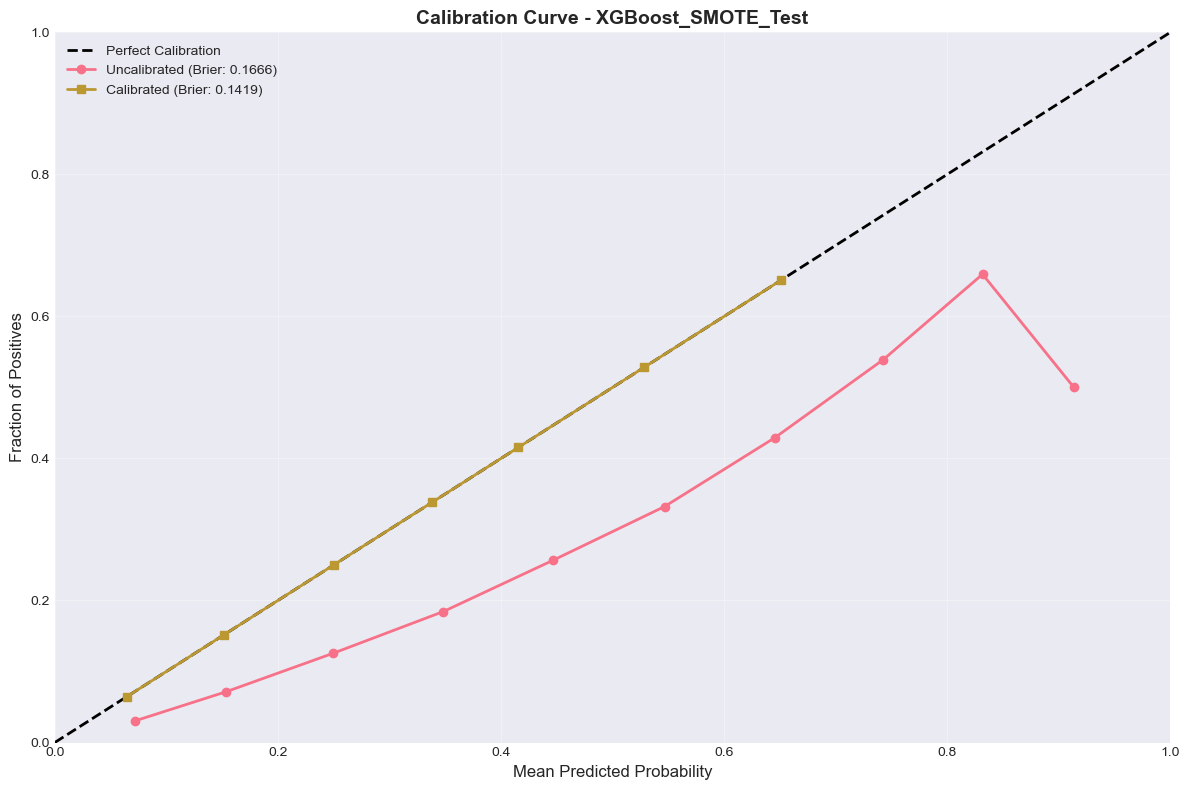

In [7]:
# Plot calibration curves
print("\nGenerating calibration plots...")

# Validation set calibration curve
evaluator.plot_calibration_curve(
    y_val, y_val_proba, y_val_calibrated,
    model_name="XGBoost_SMOTE_Validation",
    n_bins=10,
    save=True
)

# Test set calibration curve
evaluator.plot_calibration_curve(
    y_test, y_test_proba, y_test_calibrated,
    model_name="XGBoost_SMOTE_Test",
    n_bins=10,
    save=True
)

print("✓ Calibration curves saved")

## 6. Evaluate Model (Validation Set)

In [8]:
print("="*80)
print("VALIDATION SET RESULTS")
print("="*80)

val_metrics = evaluator.evaluate(
    y_val, y_val_proba,
    threshold=optimal_threshold,
    model_name="XGBoost_SMOTE_Validation"
)

print("\nKey Metrics:")
print(f"  AUC-ROC: {val_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
print(f"  Precision: {val_metrics['precision']:.4f}")
print(f"  Recall: {val_metrics['recall']:.4f}")
print(f"  F1-Score: {val_metrics['f1_score']:.4f}")
print(f"  PR-AUC: {val_metrics['pr_auc']:.4f}")
print(f"  MCC: {val_metrics['matthews_corr_coef']:.4f}")
print(f"  Cohen's Kappa: {val_metrics['cohen_kappa']:.4f}")

2025-12-10 16:34:19,566 - credit_risk_fyp.evaluation - INFO - Evaluating XGBoost_SMOTE_Validation...
INFO:credit_risk_fyp.evaluation:Evaluating XGBoost_SMOTE_Validation...
2025-12-10 16:34:19,673 - credit_risk_fyp.evaluation - INFO - XGBoost_SMOTE_Validation Results:
INFO:credit_risk_fyp.evaluation:XGBoost_SMOTE_Validation Results:
2025-12-10 16:34:19,675 - credit_risk_fyp.evaluation - INFO -   AUC-ROC: 0.7270
INFO:credit_risk_fyp.evaluation:  AUC-ROC: 0.7270
2025-12-10 16:34:19,678 - credit_risk_fyp.evaluation - INFO -   Accuracy: 0.7122
INFO:credit_risk_fyp.evaluation:  Accuracy: 0.7122
2025-12-10 16:34:19,680 - credit_risk_fyp.evaluation - INFO -   Precision: 0.3601
INFO:credit_risk_fyp.evaluation:  Precision: 0.3601
2025-12-10 16:34:19,684 - credit_risk_fyp.evaluation - INFO -   Recall: 0.5715
INFO:credit_risk_fyp.evaluation:  Recall: 0.5715
2025-12-10 16:34:19,686 - credit_risk_fyp.evaluation - INFO -   F1-Score: 0.4418
INFO:credit_risk_fyp.evaluation:  F1-Score: 0.4418


VALIDATION SET RESULTS

Key Metrics:
  AUC-ROC: 0.7270
  Accuracy: 0.7122
  Precision: 0.3601
  Recall: 0.5715
  F1-Score: 0.4418
  PR-AUC: 0.4084
  MCC: 0.2738
  Cohen's Kappa: 0.2611


## 7. Evaluate Model (Test Set)

In [9]:
print("="*80)
print("TEST SET RESULTS")
print("="*80)

test_metrics = evaluator.evaluate(
    y_test, y_test_proba,
    threshold=optimal_threshold,
    model_name="XGBoost_SMOTE_Test"
)

print("\nKey Metrics:")
print(f"  AUC-ROC: {test_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
print(f"  PR-AUC: {test_metrics['pr_auc']:.4f}")
print(f"  MCC: {test_metrics['matthews_corr_coef']:.4f}")
print(f"  Cohen's Kappa: {test_metrics['cohen_kappa']:.4f}")

2025-12-10 16:34:19,706 - credit_risk_fyp.evaluation - INFO - Evaluating XGBoost_SMOTE_Test...
INFO:credit_risk_fyp.evaluation:Evaluating XGBoost_SMOTE_Test...


TEST SET RESULTS


2025-12-10 16:34:19,821 - credit_risk_fyp.evaluation - INFO - XGBoost_SMOTE_Test Results:
INFO:credit_risk_fyp.evaluation:XGBoost_SMOTE_Test Results:
2025-12-10 16:34:19,822 - credit_risk_fyp.evaluation - INFO -   AUC-ROC: 0.7247
INFO:credit_risk_fyp.evaluation:  AUC-ROC: 0.7247
2025-12-10 16:34:19,824 - credit_risk_fyp.evaluation - INFO -   Accuracy: 0.7123
INFO:credit_risk_fyp.evaluation:  Accuracy: 0.7123
2025-12-10 16:34:19,827 - credit_risk_fyp.evaluation - INFO -   Precision: 0.3598
INFO:credit_risk_fyp.evaluation:  Precision: 0.3598
2025-12-10 16:34:19,830 - credit_risk_fyp.evaluation - INFO -   Recall: 0.5695
INFO:credit_risk_fyp.evaluation:  Recall: 0.5695
2025-12-10 16:34:19,833 - credit_risk_fyp.evaluation - INFO -   F1-Score: 0.4410
INFO:credit_risk_fyp.evaluation:  F1-Score: 0.4410



Key Metrics:
  AUC-ROC: 0.7247
  Accuracy: 0.7123
  Precision: 0.3598
  Recall: 0.5695
  F1-Score: 0.4410
  PR-AUC: 0.3990
  MCC: 0.2728
  Cohen's Kappa: 0.2604


## 8. Generate Visualizations

2025-12-10 16:34:19,847 - credit_risk_fyp.evaluation - INFO - Generating all evaluation plots for XGBoost_SMOTE_Validation...
INFO:credit_risk_fyp.evaluation:Generating all evaluation plots for XGBoost_SMOTE_Validation...


Generating evaluation plots...


2025-12-10 16:34:20,618 - credit_risk_fyp.evaluation - INFO - ROC curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\roc_curve_xgboost_smote_validation.png
INFO:credit_risk_fyp.evaluation:ROC curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\roc_curve_xgboost_smote_validation.png
2025-12-10 16:34:21,399 - credit_risk_fyp.evaluation - INFO - PR curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\pr_curve_xgboost_smote_validation.png
INFO:credit_risk_fyp.evaluation:PR curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\pr_curve_xgboost_smote_validation.png
2025-12-10 16:34:21,908 - credit_risk_fyp.evaluation - INFO - Confusion matrix saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\confusion_matrix_xgboost_smote_validation.png
INFO:credit_risk_fyp.evaluation:Confusion matrix saved to c:\Users\Faheem\Deskto

✓ All plots saved to results/figures/


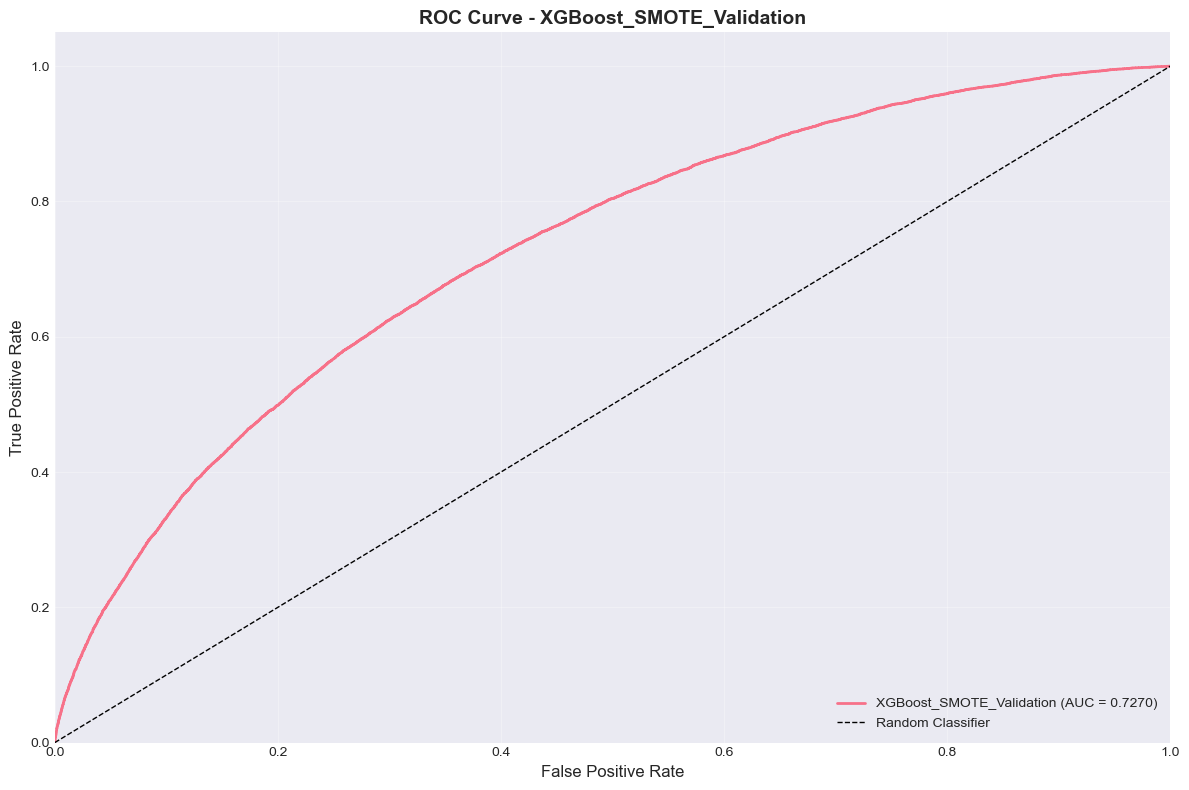

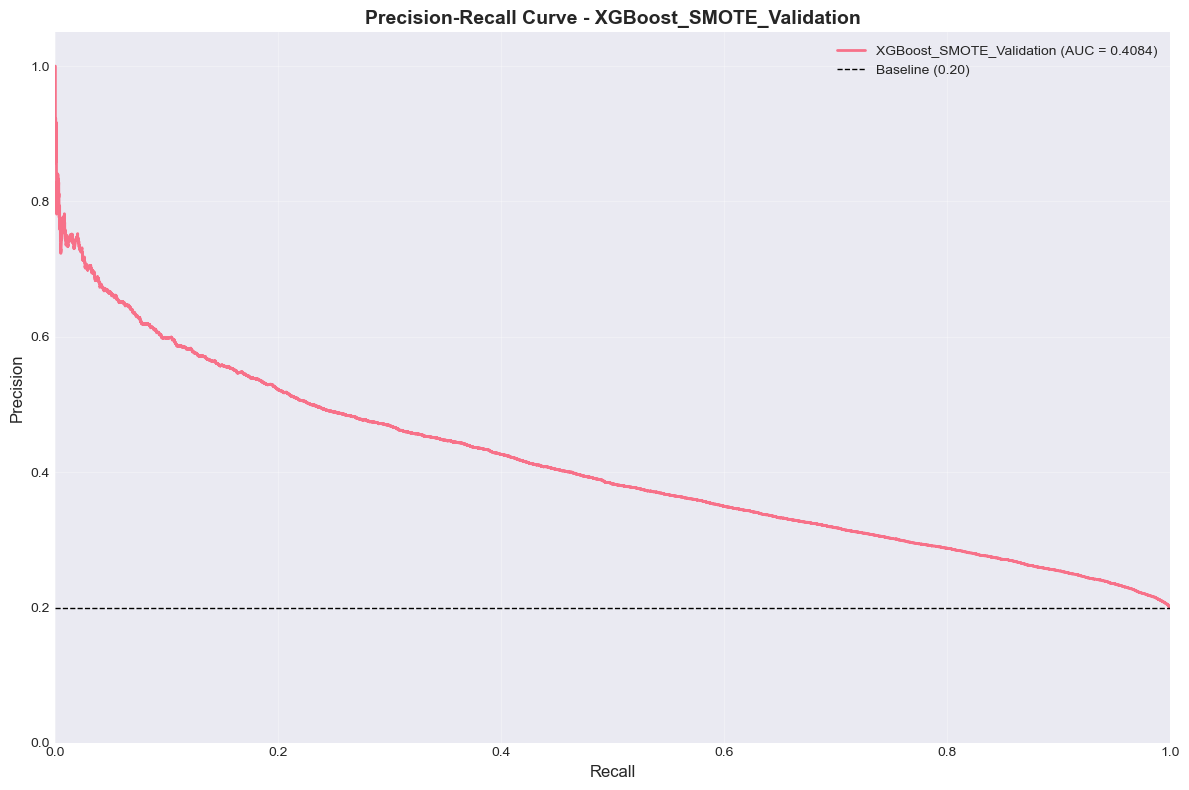

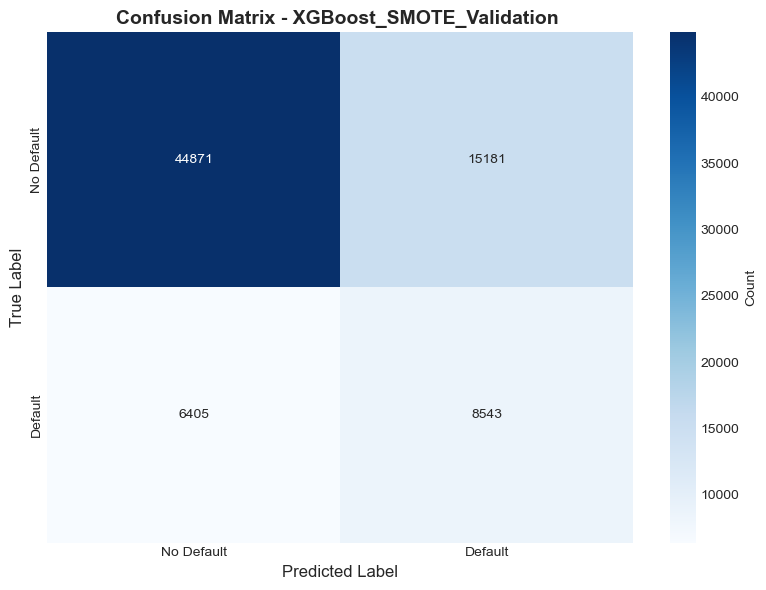

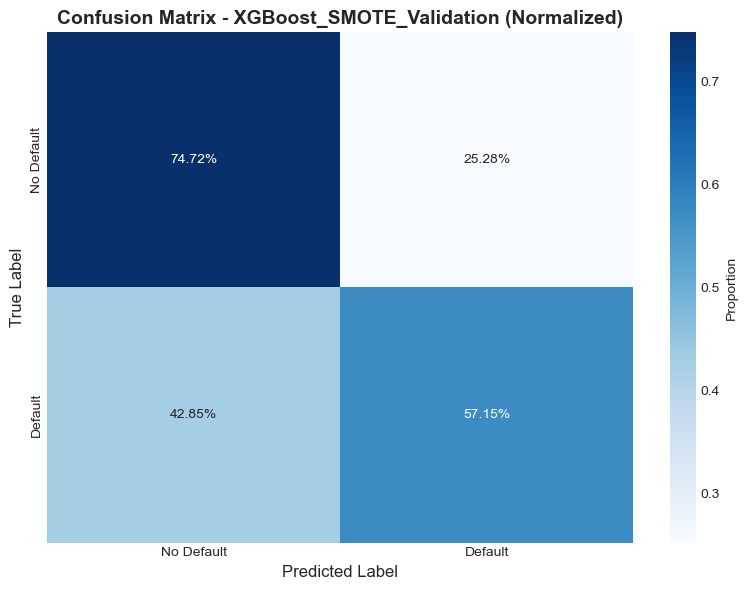

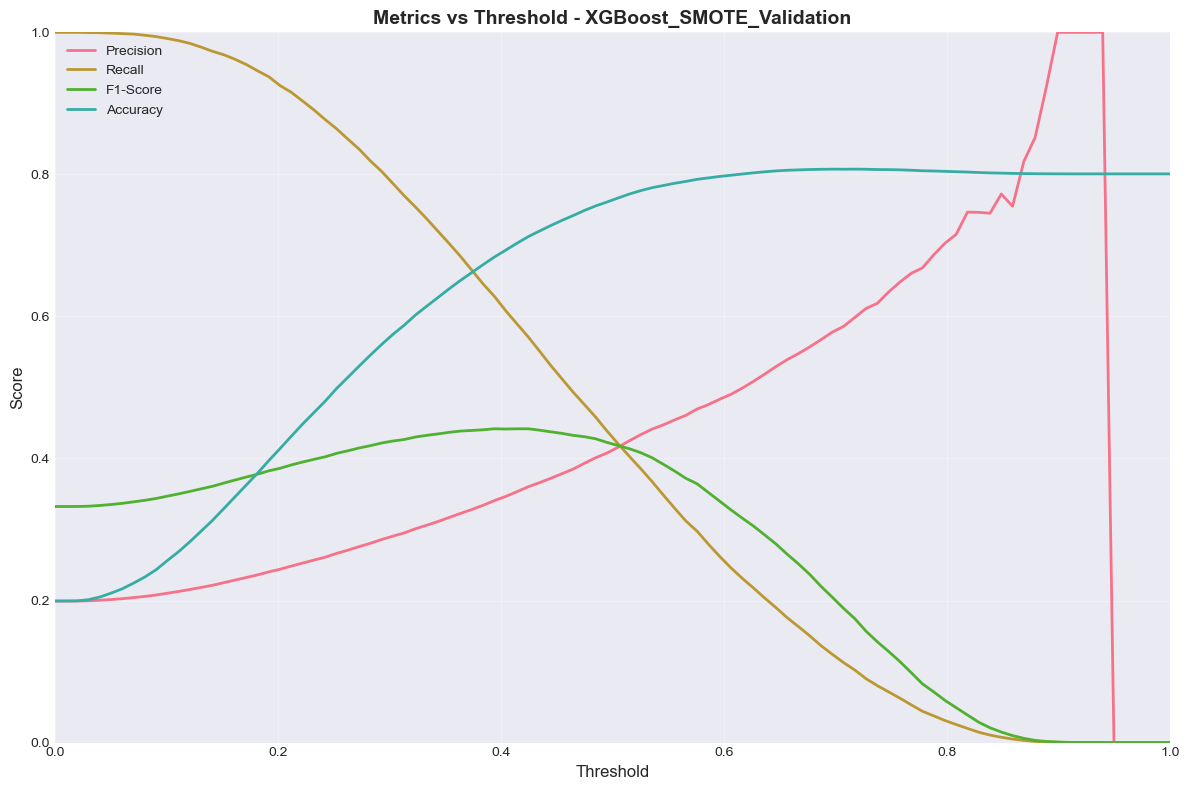

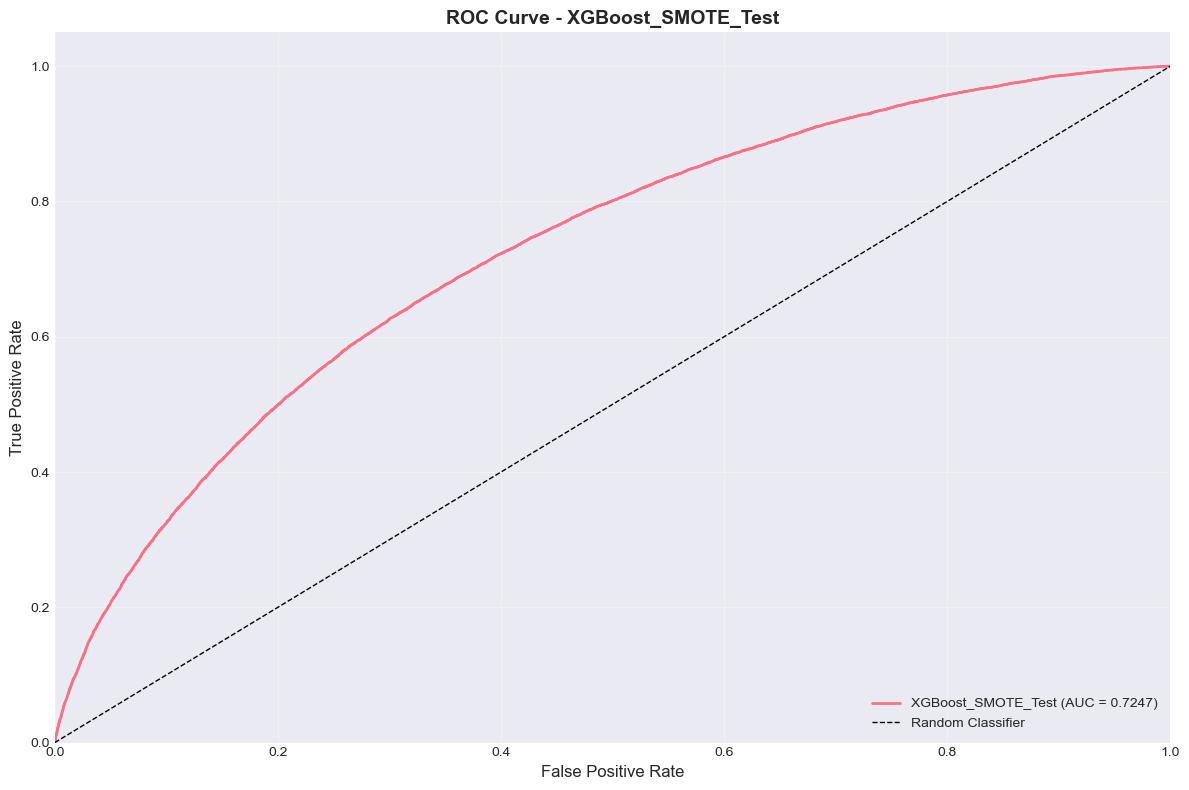

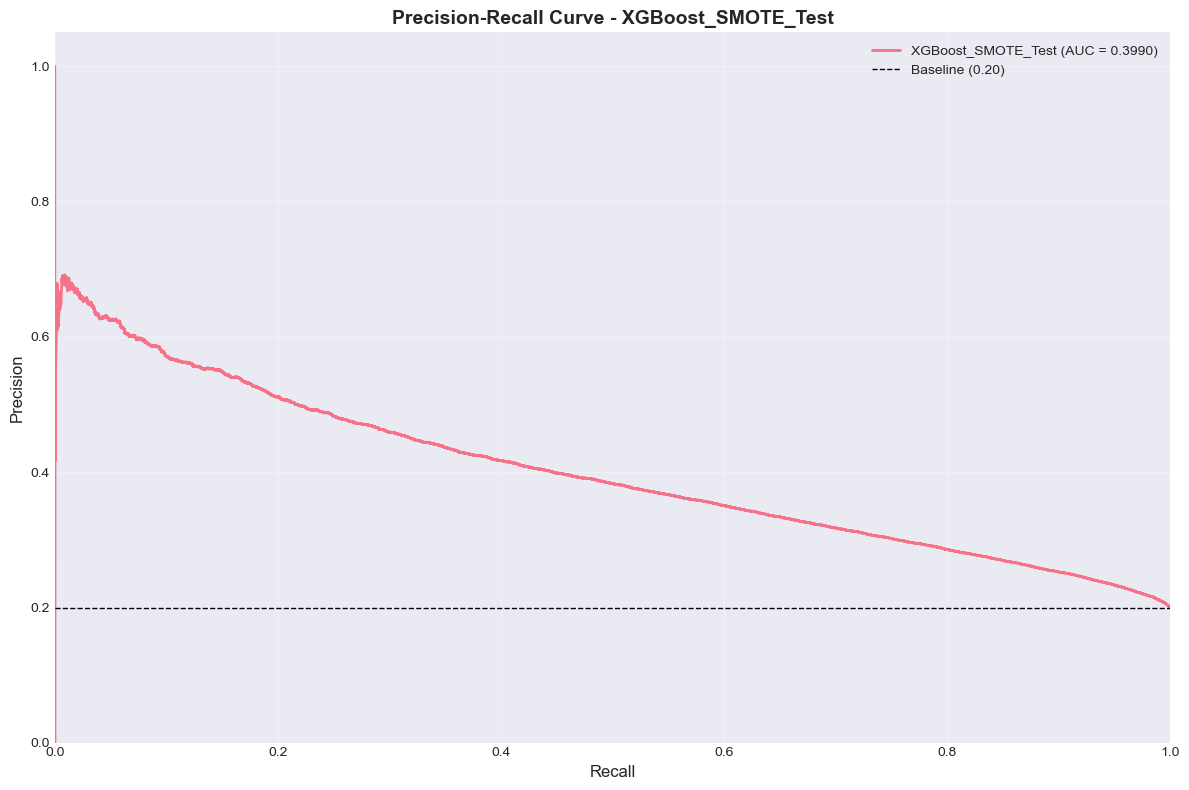

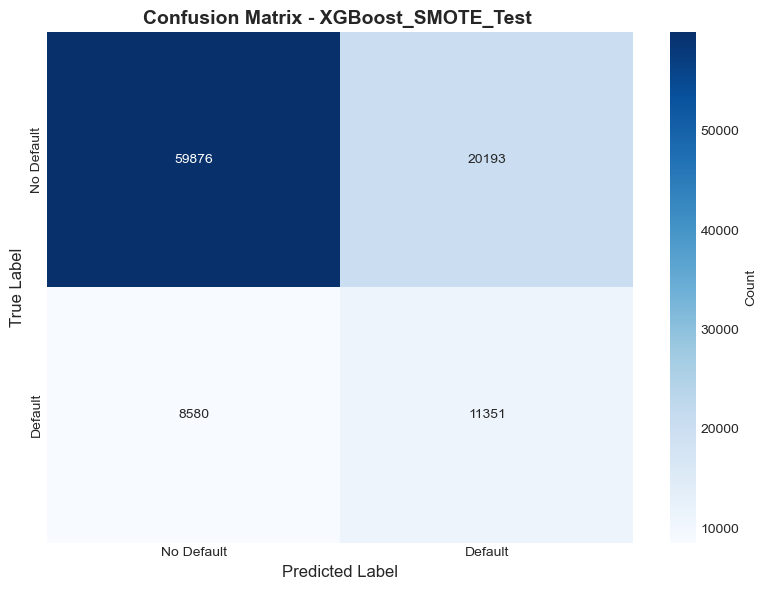

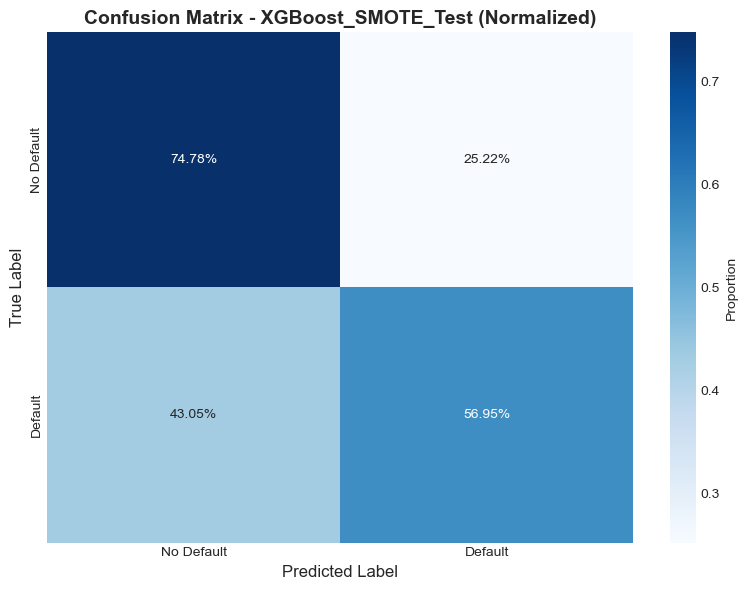

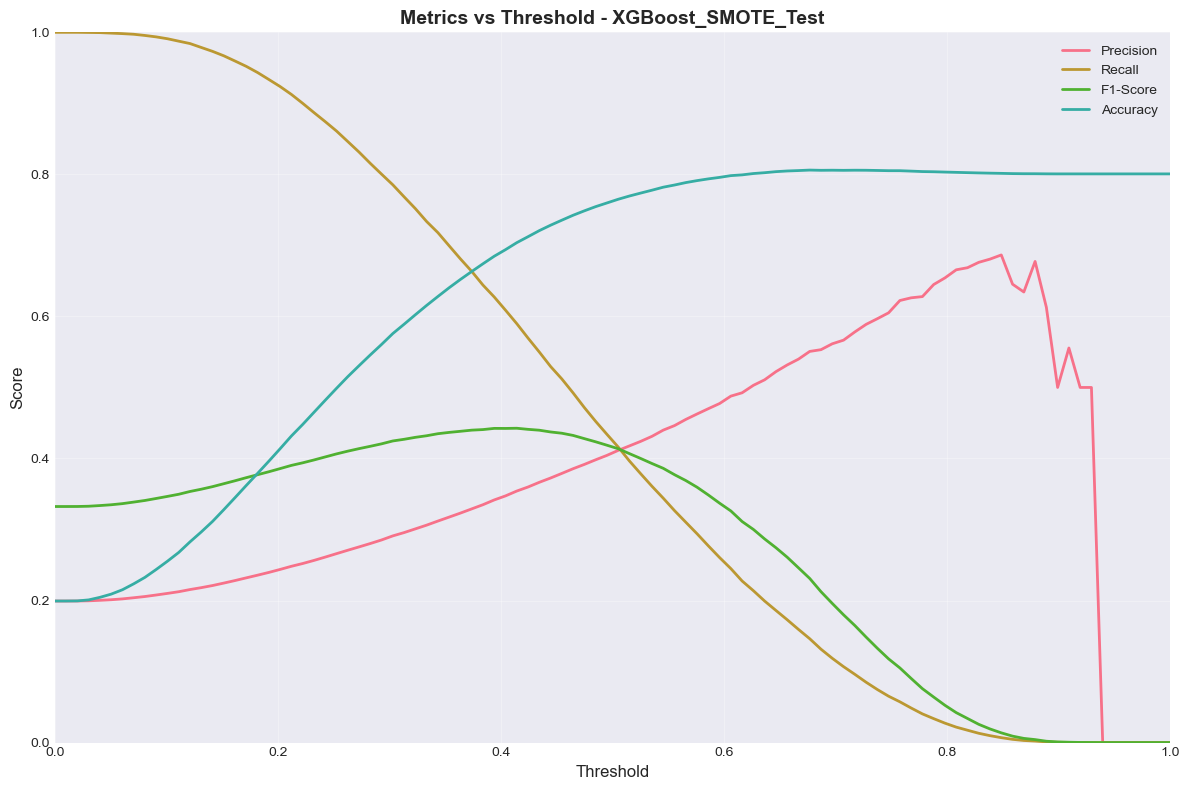

In [10]:
print("Generating evaluation plots...")

val_figures = evaluator.evaluate_all_plots(
    y_val, y_val_proba,
    model_name="XGBoost_SMOTE_Validation",
    threshold=optimal_threshold,
    save=True
)

test_figures = evaluator.evaluate_all_plots(
    y_test, y_test_proba,
    model_name="XGBoost_SMOTE_Test",
    threshold=optimal_threshold,
    save=True
)

print("✓ All plots saved to results/figures/")

## 9. Feature Importance Analysis

In [11]:
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance
importance_df = xgb_model.get_feature_importance()

print("\nTop 20 Most Important Features:\n")
print(importance_df.head(20).to_string(index=False))


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:

              feature  importance
                 term 2745.822754
  high_loan_to_income  994.484131
       home_ownership  454.985077
        income_bucket  306.827148
         inquiry_risk  207.497742
  recent_inquiry_rate  196.719986
       inq_last_6mths  193.725021
     loan_amnt_bucket  167.458710
       fico_range_low  165.073349
   num_tl_op_past_12m  154.512268
  initial_list_status  145.459885
 acc_open_past_24mths  114.366264
      fico_range_high  103.559906
             mort_acc   64.641716
        fico_dti_risk   61.443287
              purpose   52.853333
  num_rev_tl_bal_gt_0   38.868771
mths_since_recent_inq   31.570608
                  dti   26.573441
       num_actv_bc_tl   26.159288


## 10. Summary

In [12]:
from sklearn.metrics import confusion_matrix

print("="*80)
print("MODEL TRAINING SUMMARY")
print("="*80)

print(f"\n📊 DATASET INFORMATION:")
print(f"  Training samples: {len(X_train):,} (SMOTE-balanced)")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {X_train.shape[1]}")
print(f"  SMOTE ratio: {train_dist[0]/train_dist[1]:.2f}:1")

print(f"\n🎯 TEST SET PERFORMANCE:")
print(f"  AUC-ROC: {test_metrics['roc_auc']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.4f}")
# Calculate True Positive Rate (TPR, aka Recall) and False Positive Rate (FPR) for test set
# y_test and y_test_pred are assumed to be available, as well as optimal_threshold, y_test_proba

y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

print(f"  TPR (Recall): {tpr:.4f}")
print(f"  FPR: {fpr:.4f}")

print(f"\n💾 SAVED ARTIFACTS:")
print(f"  Model: {model_path}")
print(f"  Figures: results/figures/")

print(f"\n✅ TRAINING COMPLETE!")
print("="*80)

MODEL TRAINING SUMMARY

📊 DATASET INFORMATION:
  Training samples: 364,313 (SMOTE-balanced)
  Validation samples: 75,000
  Test samples: 100,000
  Features: 103
  SMOTE ratio: 2.50:1

🎯 TEST SET PERFORMANCE:
  AUC-ROC: 0.7247
  Precision: 0.3598
  Recall: 0.5695
  F1-Score: 0.4410
  Optimal Threshold: 0.4242
  TPR (Recall): 0.5695
  FPR: 0.2522

💾 SAVED ARTIFACTS:
  Model: c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl
  Figures: results/figures/

✅ TRAINING COMPLETE!
